In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import special as sp
import scipy.integrate as integrate
import scipy.stats as st
from pylab import *

import lmfit as lf

import pickle

# Yield Distribution

The purpose of this notebook is to illustrate where in the parameter space the ionization yield distribution behaves pathologically. Specifically, the notebook shows some contour plots of the log of the divergence between normal approximations and the true yield distribution, as well as histogram/density plots of specific cases of parameters to visually represent difference between fits and true distribution. 

The following block of code is to set up functions for the contour plots and yield histograms as well as run a test case for the yield histogram.

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


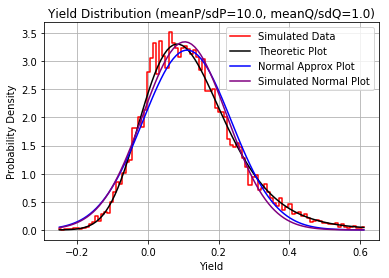

0.05196154678459054
0.05101486362574821


In [16]:
def ratio_dist(z, res_p, res_q, r1, k1):
    F1 = np.exp(-0.5*(res_q**2 + res_p**2)) / (np.pi*(r1*z**2 + (1/r1)*(1+k1*z)*2))
    
    G11 = (r1*(z*res_q*r1 + (1+k1*z)*res_p)) / (np.sqrt(2*np.pi)*np.power(z**2 * r1**2 + (1+k1*z)**2, 3/2))
    G12 = np.exp(-(z*res_p*r1 - (1+k1*z)*res_q)**2 / (2*(z**2 * r1**2 + (1+k1*z)**2)))
    G13 = sp.erf((z*res_q + (1+k1*z)*res_p/r1) / np.sqrt(2*(z**2 + (1+k1*z)**2 / r1**2)))

    return F1 + G11*G12*G13

def theta_dist(theta, res_p, res_q, r1, k1):
    alph = (res_q**2 + res_p**2)
    phi = np.arctan((r1*res_p-k1*res_q)/((r1*res_q+k1*res_p)))
    F1 = (np.exp(-0.5*alph) / np.pi)
    
    G11 = np.sqrt(alph/(2*math.pi))*np.sin(theta+phi)
    G12 = np.exp(((np.sin(theta+phi)**2)-1)*alph/2)
    G13 = sp.erf(np.sqrt(alph/2)*np.sin(theta+phi))

    return F1 + G11*G12*G13

def norm_dist(x,mu,sigma):
    return np.exp(-(((x-mu)/sigma)**2)/2)/np.sqrt(2*np.pi*sigma**2)

def DivergenceMetricIntegrand(x, mu, sigma, res_p, res_q, r1, k1):
    return norm_dist(x,mu,sigma)*np.log(norm_dist(x,mu,sigma)/ratio_dist(x,res_p,res_q,r1,k1))

def DivergenceMetric(mu, sigma, res_p, res_q, r1, k1):
    bound = integrate.quad(DivergenceMetricIntegrand,mu-10*sigma,mu+10*sigma,args=(mu, sigma, res_p, res_q, r1, k1))[0]
    return bound

def vIntegrand(t,x):
    return -np.log(t)*(np.exp(x*(t-1)))/(2*(1-t))

def vformula(d):
    return integrate.quad(vIntegrand,0,1,args=(((d**2)/2)))[0]
    
def H(x,r1,k1):
    return ((r1*np.tan(x)-k1)/(r1**2+k1**2))

def Hp(x,r1,k1):
    return r1/((r1**2+k1**2)*(np.cos(x)**2))

def invH(x,r1,k1):
    return np.arctan(((r1**2+k1**2)*x+k1)/r1)


#Normal Approx(Theta Method)
def meanZ(res_p,res_q,r1,k1):
    phi = np.arctan((r1*res_p-k1*res_q)/(r1*res_q+k1*res_p))
    if phi == 0:
        meanTheta2 = 0
    else:
        meanTheta2 = -phi+math.pi*(abs(phi)/phi)/2
    return H(meanTheta2,r1,k1)
def sdZ(res_p,res_q,r1,k1):
    phi = np.arctan((r1*res_p-k1*res_q)/((r1*res_q+k1*res_p)))
    if phi == 0:
        meanTheta2 = 0
    else:
        meanTheta2 = -phi+math.pi*(abs(phi)/phi)/2
    sdTheta2 = np.sqrt(vformula(np.sqrt(res_p**2+res_q**2)))
    return Hp(meanTheta2,r1,k1)*sdTheta2
    

def YieldSample(meanP,sdP,meanQ,sdQ,k):
    N0000 = 2500
    N = 4*N0000 - 1
    r = sdP/sdQ
    
    #Data Generation
    np.random.seed(14)
    Pdata = np.random.normal(meanP,sdP,N)
    Qdata = np.random.normal(meanQ,sdQ,N)
    Zdata = (Qdata) / (Pdata-k*Qdata)

    #Outlier Rejection
    Zdata = np.sort(Zdata)
    IQRZ = (Zdata[(3*(N+1))//4]-Zdata[(N+1)//4])
    medianZ = Zdata[(N+1)//2]
    OutLZ = []
    OutUZ = []
    for i in range(N):
        if (Zdata[i] < (Zdata[(N+1)//4] - 2.5 * IQRZ)):
            OutLZ.append(i)
        elif (Zdata[i] > (Zdata[(3*(N+1))//4] + 2.5 * IQRZ)):
            OutUZ.append(i)
    OutZ = np.concatenate((OutLZ,OutUZ))
    ZdataOut = np.delete(Zdata,OutZ)
    
    #Histogram
    density = True
    bins = 100
    hist, bin_edges = np.histogram(ZdataOut, bins, density=density)
    hist1, bin_edges1 = np.histogram(ZdataOut, bins, density=False)
    bin_centers1 = (bin_edges1[:-1]+bin_edges1[1:])/2
    errors1 = np.sqrt(hist1)
    errors = errors1*(np.sum(hist)/np.sum(hist1))
    #Simulated Normal Approximation
    sigdata = np.sqrt(hist1)/(N*(bin_edges[1]-bin_edges[0]))
    weightdata = []
    for i in sigdata:
        if i == 0:
            weightdata.append(0)
        else:
            weightdata.append(1/i)
            
    weightdata = np.ones(len(sigdata))
    l_mod = lf.Model(norm_dist)
    params = l_mod.make_params(mu=meanZ((meanP/sdP), (meanQ/sdQ), r, k), sigma=sdZ((meanP/sdP), (meanQ/sdQ), r, k))
    l_fit = l_mod.fit(hist, params, x=bin_centers1, weights=weightdata)
    l_dict = l_fit.best_values
    l_mu = l_dict["mu"]
    l_sigma = l_dict["sigma"]
    
    return Zdata, ZdataOut, l_mu, l_sigma, hist, bin_edges, errors
    
def YieldPlot(meanP,sdP,meanQ,sdQ,k):
    r = sdP/sdQ
    Zdata, ZdataOut, simMeanZ, simSdZ, hist, bin_edges, errors = YieldSample(meanP,sdP,meanQ,sdQ,k)
    
    #Theoretical Plot
    f = ratio_dist(bin_edges[0:-1], (meanP/sdP), (meanQ/sdQ), r, k)
    fN = norm_dist(bin_edges[0:-1],meanZ((meanP/sdP), (meanQ/sdQ), r, k),sdZ((meanP/sdP), (meanQ/sdQ), r, k))
    fSN = norm_dist(bin_edges[0:-1],simMeanZ,simSdZ)

    #chisq1 = sum(((fSN-hist)*weightdata)**2)
    #chisq2 = sum(((fN-hist)*weightdata)**2)
    
    plt.figure()
    plt.plot(bin_edges[0:-1], (hist), drawstyle = "steps-mid", color="red", label = "Simulated Data")
    plt.plot(bin_edges[0:-1], f, color="black", label = "Theoretic Plot")
    plt.plot(bin_edges[0:-1], fN, color="blue", label = "Normal Approx Plot")
    plt.plot(bin_edges[0:-1], fSN, color="purple", label = "Simulated Normal Plot")
    plt.grid()
    plt.xlabel("Yield")
    plt.ylabel("Probability Density")
    plt.title("Yield Distribution (meanP/sdP=" + str(round(meanP/sdP,5)) + ", meanQ/sdQ=" + str(round(meanQ/sdQ,5)) + ")")
    #plt.yscale("log")
    plt.legend(loc = 1)
    plt.show()
    print(DivergenceMetric(simMeanZ,simSdZ,(meanP/sdP), (meanQ/sdQ), r, k))
    print(DivergenceMetric(meanZ((meanP/sdP), (meanQ/sdQ), r, k),sdZ((meanP/sdP), (meanQ/sdQ), r, k),(meanP/sdP), (meanQ/sdQ), r, k))

YieldPlot(10,1,1,1,1)


(above is a test yield plot for specific parameters exactly of the form of what is seen below the contour plots)

In [3]:
r = 2.854
k = 1.21
p = np.arange(1, 55, 2)
q = np.arange(1, 65, 2)
pp, qq = np.meshgrid(p, q, sparse=True)

z = [[0 for x in range(len(p))] for y in range(len(q))]
z2 = [[0 for x in range(len(p))] for y in range(len(q))]
thetaContData = z
simContData = z2

for q_i in range(len(q)):
    for p_i in range(len(p)):
        thetaContData[q_i][p_i] = np.log(DivergenceMetric(meanZ(p[p_i],q[q_i],r,k),sdZ(p[p_i],q[q_i],r,k),p[p_i],q[q_i],r,k))
        sampstuff = YieldSample(p[p_i]*r,r,q[q_i],1,k)
        simMeanZ2 = sampstuff[2]
        simSdZ2 = sampstuff[3]
        simContData[q_i][p_i] = np.log(DivergenceMetric(simMeanZ2,simSdZ2,p[p_i],q[q_i],r,k))
        #print(z[q_i][p_i])


pickle.dump(thetaContData, open( "thetaContData.p", "wb" ) )
pickle.dump(simContData, open( "simContData.p", "wb" ) )

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


# Plots

The divergece metric measures difference between 2 random variables in the same sample space, outputting a non-negative value where a value of 0 implies identical distributions. In the following code, log divergence was used is because the values get exceedingly large and a value of 0 is impossible as the distributions don't have the same form, thus log divergence always exists and is reasonable in scale.

Below, there are 2 contour plots of the log divergence between a normal approximation and the true yield distribution. The first plot uses a normal distribution calculated using statistical theory and transforming random variables, while the second plot uses a normal approximation based off of simulated data. Remember, these plots are in the parameter space.

Additionally, the blue points on the contour plots correspond to the histograms below which correspond to specific values for the parameters. The numbers printed below are the divergence between normal approximations and the yield distribution, where the first corresponds to the divergence between the simulated normal approximation (purple) and theoretical yield distribution (black), while the second corresponds to the divergence between the normal approximation using transformations (blue) and the theoretical yield distribution (black).

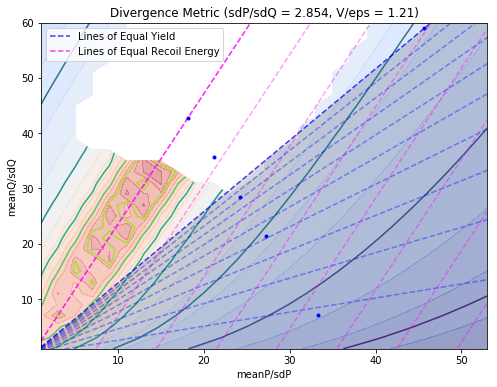

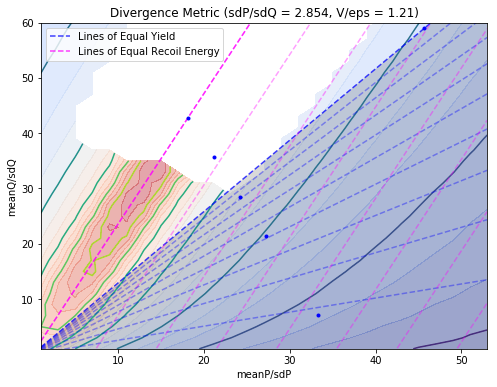

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


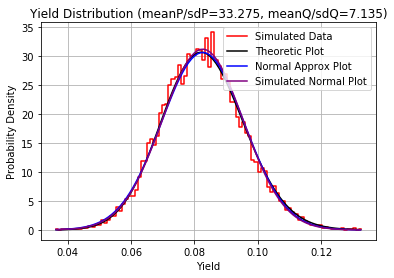

0.0017539534468457157
0.0014801390553797885


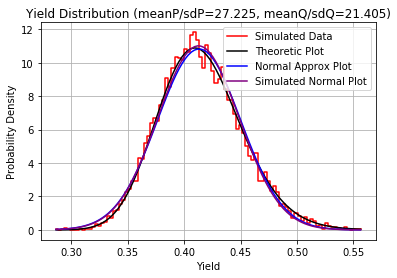

0.010244078608464744
0.009766930850410183


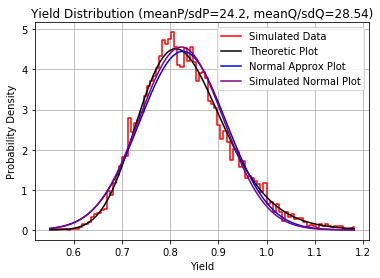

0.029098478108081284
0.02745300121644787


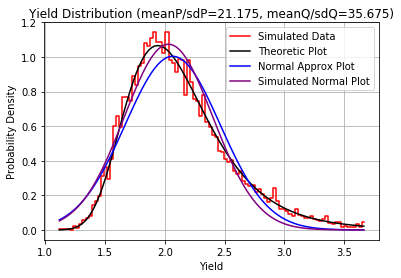

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars


nan
nan


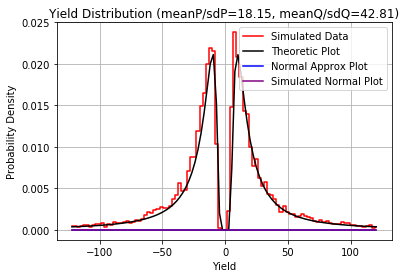

nan
nan


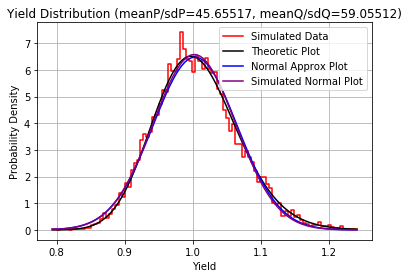

0.010012557613967991
0.009307605692594253


In [27]:
z = pickle.load( open( "thetaContData.p", "rb" ) )
z2 = pickle.load( open( "simContData.p", "rb" ) )

XEvalPts = np.array([27.5 , 22.5 , 20 , 17.5 , 15])*k
YEvalPts = np.array([2.5  , 7.5  , 10 , 12.5 , 15])*r
XEvalPts = np.append(XEvalPts,[331/7.25])
YEvalPts = np.append(YEvalPts,[150/2.54])

alpha1 = .75  *1
alpha2 = alpha1/2
alpha3 = .15  *1
alpha4 = .4   *1
Grid = False


YieldColor = "blue"
ErColor = "magenta"
ShadeColor = "black"
PointsMark = "b."

FigSize  = (8,6)

plt.figure(figsize = FigSize)
if Grid == True:
    plt.grid()
plt.contourf(p,q,z, 20, cmap='coolwarm',alpha=alpha4)

plt.plot(p,p*r/(k+1), color = YieldColor, linestyle = "--", alpha=alpha1,label="Lines of Equal Yield")
plt.plot(p,p*r/k, color = ErColor, linestyle = "--", alpha=alpha1,label="Lines of Equal Recoil Energy")
plt.fill_between(p,0,p*r/(1+k),facecolor = ShadeColor, alpha=alpha3)
#"""
for pltindex in range(9):
    plt.plot(p,p*r/(k+1/(.1*(pltindex+1))), color = YieldColor, linestyle = "--", alpha=alpha2)
    plt.plot(p,(p*r-20*pltindex)/k, color = ErColor, linestyle = "--", alpha=alpha2)
#"""
plt.contour(p,q,z)
plt.plot(XEvalPts,YEvalPts,PointsMark)
plt.title("Divergence Metric (sdP/sdQ = " + str(r) + ", V/eps = " + str(k) + ")")
plt.xlabel("meanP/sdP")
plt.ylabel("meanQ/sdQ")
plt.ylim(1,60)
plt.legend()
plt.show()



plt.figure(figsize = FigSize)
if Grid == True:
    plt.grid()
plt.contourf(p,q,z2, 20, cmap='coolwarm',alpha=alpha4)

plt.plot(p,p*r/(k+1), color = YieldColor, linestyle = "--", alpha=alpha1,label="Lines of Equal Yield")
plt.plot(p,p*r/k, color = ErColor, linestyle = "--", alpha=alpha1,label="Lines of Equal Recoil Energy")
plt.fill_between(p,0,p*r/(1+k),facecolor = ShadeColor, alpha=alpha3)
#"""
for pltindex in range(9):
    plt.plot(p,p*r/(k+1/(.1*(pltindex+1))), color = YieldColor, linestyle = "--", alpha=alpha2)
    plt.plot(p,(p*r-20*pltindex)/k, color = ErColor, linestyle = "--", alpha=alpha2)
#"""
plt.contour(p,q,z2)
plt.plot(XEvalPts,YEvalPts,PointsMark)
plt.title("Divergence Metric (sdP/sdQ = " + str(r) + ", V/eps = " + str(k) + ")")
plt.xlabel("meanP/sdP")
plt.ylabel("meanQ/sdQ")
plt.ylim(1,60)
plt.legend()
plt.show()


for indexi in range(len(XEvalPts)):
    pi = XEvalPts[indexi]
    qi = YEvalPts[indexi]
    YieldPlot(r*pi,r,qi,1,k)

# Plots (part 2)
This Section is almost the exact same as what has come before, however the following code accounts for the fact that $E_p$ and $E_q$ are dependent on each other through the variable $N$ which is the number of electron whole pairs generated from the collision.

The following block of code is to set up functions for the contour plots and yield histograms as well as run a test case for the yield histogram.

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


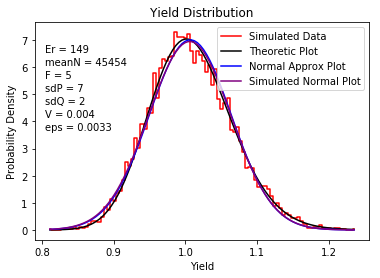

0.009190542287695346
0.008085402871687842


In [22]:
def ratio_dist2(x, Er,meanN,F,sdP,sdQ,V,e):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(e*sdP)**2)
    A = ((((x*(V/e)+1)*sdQ)**2)+((x*sdP)**2)+(F*meanN*e**2))/(2*k)
    B = ((V/e)*(sdQ**2)*(Er*x+e*meanN)+x*e*meanN*(((V*sdQ/e)**2)+(sdP**2))+Er*((sdQ**2)+(F*meanN*e**2)))/(k)
    C = ((((meanN*V+Er)*sdQ)**2)+(((meanN*sdP)**2)+(F*meanN*Er**2))*(e**2))/(2*k)
    D = (B**2/(4*A)) - C
    ans = (1/(2*np.sqrt(np.pi*k)))*(1/A)*((np.exp(-C)/(np.sqrt(np.pi))) + B/(2*np.sqrt(A))*np.exp(D)*erf(B/(2*np.sqrt(A))))

    return ans

def theta_dist2(theta,Er,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    alph = ((sdQ*(Er+V*meanN))**2+(eps**2)*((meanN*sdP)**2+F*meanN*(Er**2)))/k
    phi = np.arctan(Er*np.sqrt(k)/((sdP**2+(V*sdQ/eps)**2)*eps*meanN+(V/eps)*Er*sdQ**2))
    F1 = (np.exp(-0.5*alph) / np.pi)
    
    G11 = np.sqrt(alph/(2*math.pi))*np.sin(theta+phi)
    G12 = np.exp(((np.sin(theta+phi)**2)-1)*alph/2)
    G13 = sp.erf(np.sqrt(alph/2)*np.sin(theta+phi))

    return F1 + G11*G12*G13

def DivergenceMetricIntegrand2(x, mu, sigma, Er,meanN,F,sdP,sdQ,V,eps):
    return norm_dist(x,mu,sigma)*np.log(norm_dist(x,mu,sigma)/ratio_dist2(x,Er,meanN,F,sdP,sdQ,V,eps))

def DivergenceMetric2(mu, sigma, Er,meanN,F,sdP,sdQ,V,eps):
    bound = integrate.quad(DivergenceMetricIntegrand2,mu-10*sigma,mu+10*sigma,args=(mu, sigma, Er,meanN,F,sdP,sdQ,V,eps))[0]
    return bound

def H2(x,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    return ((np.sqrt(k)*np.tan(x)-(V/eps)*sdQ**2)/(sdP**2+((V/eps)*sdQ)**2))

def Hp2(x,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    return np.sqrt(k)/((sdP**2+((V/eps)*sdQ)**2)*(np.cos(x)**2))

def invH2(x,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    return np.arctan(((sdP**2+((V/eps)*sdQ)**2)*x+(V/eps)*sdQ**2)/np.sqrt(k))

#Normal Approx(Theta Method)
def meanZ2(Er,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    phi = np.arctan(Er*np.sqrt(k)/((sdP**2+(V*sdQ/eps)**2)*eps*meanN+(V/eps)*Er*sdQ**2))
    if phi == 0:
        meanTheta2 = 0
    else:
        meanTheta2 = -phi+math.pi*(abs(phi)/phi)/2
    return H2(meanTheta2,meanN,F,sdP,sdQ,V,eps)

def sdZ2(Er,meanN,F,sdP,sdQ,V,eps):
    k=(sdP*sdQ)**2+F*meanN*((V*sdQ)**2+(eps*sdP)**2)
    alph = ((sdQ*(Er+V*meanN))**2+(eps**2)*((meanN*sdP)**2+F*meanN*(Er**2)))/k
    phi = np.arctan(Er*np.sqrt(k)/((sdP**2+(V*sdQ/eps)**2)*eps*meanN+(V/eps)*Er*sdQ**2))
    if phi == 0:
        meanTheta2 = 0
    else:
        meanTheta2 = -phi+math.pi*(abs(phi)/phi)/2
    sdTheta2 = np.sqrt(vformula(np.sqrt(alph)))
    return Hp2(meanTheta2,meanN,F,sdP,sdQ,V,eps)*sdTheta2

def YieldSample2(Er,meanN,F,sdP,sdQ,V,eps):
    N0000 = 2500
    N = 4*N0000 - 1
    
    #Data Generation
    np.random.seed(14)
    
    #Z=(eN+Q)/(Er+P-(V/e)Q)
    Ndata = np.random.normal(meanN,np.sqrt(meanN*F),N)
    Qdata = np.random.normal(0,sdQ,N)
    Pdata = np.random.normal(0,sdP,N)
    Zdata = (eps*Ndata+Qdata) / (Er+Pdata-(V/eps)*Qdata)


    #Outlier Rejection
    Zdata = np.sort(Zdata)
    IQRZ = (Zdata[(3*(N+1))//4]-Zdata[(N+1)//4])
    medianZ = Zdata[(N+1)//2]
    OutLZ = []
    OutUZ = []
    for i in range(N):
        if (Zdata[i] < (Zdata[(N+1)//4] - 2.5 * IQRZ)):
            OutLZ.append(i)
        elif (Zdata[i] > (Zdata[(3*(N+1))//4] + 2.5 * IQRZ)):
            OutUZ.append(i)
    OutZ = np.concatenate((OutLZ,OutUZ))
    ZdataOut = np.delete(Zdata,OutZ)
    
    #Histogram
    density = True
    bins = 100
    hist, bin_edges = np.histogram(ZdataOut, bins, density=density)
    hist1, bin_edges1 = np.histogram(ZdataOut, bins, density=False)
    bin_centers1 = (bin_edges1[:-1]+bin_edges1[1:])/2
    errors1 = np.sqrt(hist1)
    errors = errors1*(np.sum(hist)/np.sum(hist1))
    
    #Simulated Normal Approximation
    sigdata = np.sqrt(hist1)/(N*(bin_edges[1]-bin_edges[0]))
    weightdata = []
    for i in sigdata:
        if i == 0:
            weightdata.append(0)
        else:
            weightdata.append(1/i)
            
    weightdata = np.ones(len(sigdata))
    l_mod = lf.Model(norm_dist)
    params = l_mod.make_params(mu=meanZ2(Er,meanN,F,sdP,sdQ,V,eps), sigma=sdZ2(Er,meanN,F,sdP,sdQ,V,eps))
    l_fit = l_mod.fit(hist, params, x=bin_centers1, weights=weightdata)
    l_dict = l_fit.best_values
    l_mu = l_dict["mu"]
    l_sigma = l_dict["sigma"]
    
    return Zdata, ZdataOut, l_mu, l_sigma, hist, bin_edges, errors

def YieldPlot2(Er,meanN,F,sdP,sdQ,V,eps):
    Zdata, ZdataOut, simMeanZ, simSdZ, hist, bin_edges, errors = YieldSample2(Er,meanN,F,sdP,sdQ,V,eps)
    
    f = ratio_dist2(bin_edges[0:-1],Er,meanN,F,sdP,sdQ,V,eps)
    fN = norm_dist(bin_edges[0:-1],meanZ2(Er,meanN,F,sdP,sdQ,V,eps),sdZ2(Er,meanN,F,sdP,sdQ,V,eps))
    fSN = norm_dist(bin_edges[0:-1],simMeanZ,simSdZ)
    
    plt.figure()
    plt.plot(bin_edges[0:-1], (hist), drawstyle = "steps-mid", color="red", label = "Simulated Data")
    plt.plot(bin_edges[0:-1], f, color="black", label = "Theoretic Plot")
    plt.plot(bin_edges[0:-1], fN, color="blue", label = "Normal Approx Plot")
    plt.plot(bin_edges[0:-1], fSN, color="purple", label = "Simulated Normal Plot")
    plt.xlabel("Yield")
    plt.ylabel("Probability Density")
    plt.title("Yield Distribution")
    plt.figtext(.15, .775, "Er = " + str(round(Er,1)))
    plt.figtext(.15, .73, "meanN = " + str(round(meanN,1)))
    plt.figtext(.15, .685, "F = " + str(round(F,5)))
    plt.figtext(.15, .64, "sdP = " + str(round(sdP,5)))
    plt.figtext(.15, .595, "sdQ = " + str(round(sdQ,5)))
    plt.figtext(.15, .55, "V = " + str(round(V,5)))
    plt.figtext(.15, .505, "eps = " + str(round(eps,5)))
    plt.legend(loc = 1)
    plt.show()
    print(DivergenceMetric2(simMeanZ,simSdZ,Er,meanN,F,sdP,sdQ,V,eps))
    print(DivergenceMetric2(meanZ2(Er,meanN,F,sdP,sdQ,V,eps),sdZ2(Er,meanN,F,sdP,sdQ,V,eps),Er,meanN,F,sdP,sdQ,V,eps))



YieldPlot2(149,45454,5,7,2,.004,.0033)


In [6]:
[F,sdP,sdQ,V,eps] = [5,7,2,.004,.0033]



#ErGrid = np.arange(1, 201, 5)
#meanNGrid = np.arange(1, 50001, 1000)
p = np.arange(1, 55, 2)
q = np.arange(1, 65, 2)
pp, qq = np.meshgrid(p, q, sparse=True)
z = [[0 for x in range(len(p))] for y in range(len(q))]
z2 = [[0 for x in range(len(p))] for y in range(len(q))]
thetaContData = z
simContData = z2

for q_i in range(len(q)):
    for p_i in range(len(p)):
        pi = p[p_i]
        qi = q[q_i]
        meanNi = (F/2)*(qi**2) + qi*np.sqrt(((sdQ/eps)**2)+((F*qi/2)**2))
        Eri = -V*meanNi+pi*np.sqrt(sdP**2+(V**2)*F*meanNi)
        thetaContData[q_i][p_i] = np.log(DivergenceMetric2(meanZ2(Eri,meanNi,F,sdP,sdQ,V,eps),sdZ2(Eri,meanNi,F,sdP,sdQ,V,eps),Eri,meanNi,F,sdP,sdQ,V,eps))
        #sampstuff = YieldSample2(ErGrid[p_i],meanNGrid[q_i],F,sdP,sdQ,V,eps)
        #simMeanZ2 = sampstuff[2]
        #simSdZ2 = sampstuff[3]
        #simContData[q_i][p_i] = np.log(DivergenceMetric2(simMeanZ2,simSdZ2,ErGrid[p_i],meanNGrid[q_i],F,sdP,sdQ,V,eps))


pickle.dump(thetaContData, open( "thetaContData2.p", "wb" ) )
#pickle.dump(simContData, open( "simContData2.p", "wb" ) )

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


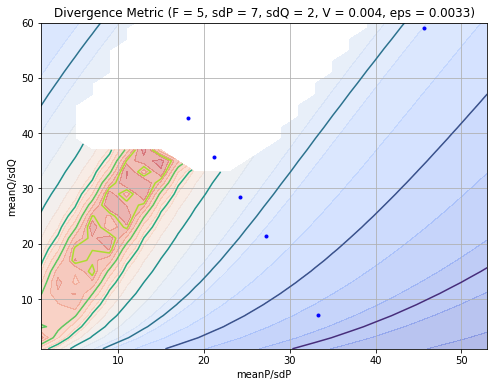

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


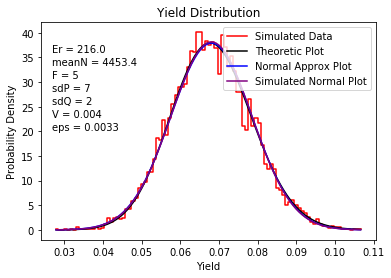

0.0010959573958349896
0.00106433050557012


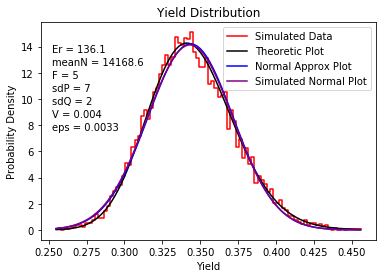

0.0083139987634084
0.007340332015764295


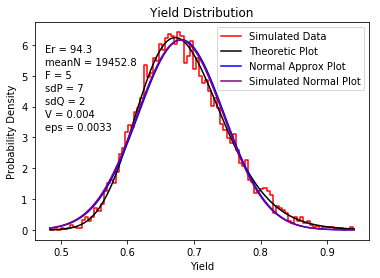

0.02247201704343093
0.019776022981645887


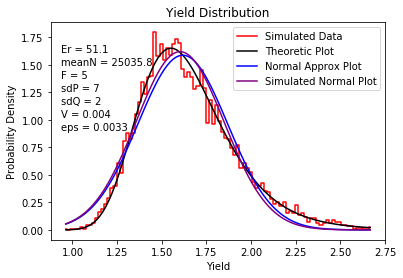

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


nan
nan


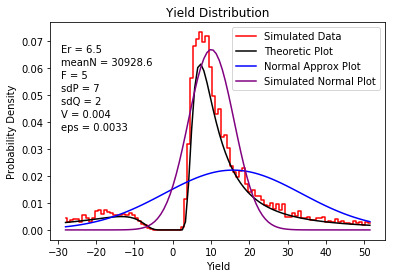

inf
inf


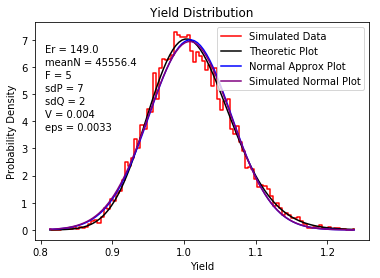

0.009182421904446377
0.008083827945560135


In [24]:
z = pickle.load( open( "thetaContData2.p", "rb" ) )
#z2 = pickle.load( open( "simContData2.p", "rb" ) )


FigSize  = (8,6)

plt.figure(figsize = FigSize)
plt.grid()
plt.contourf(p,q,z, 20, cmap='coolwarm',alpha=alpha4)
plt.contour(p,q,z)
plt.plot(XEvalPts,YEvalPts,PointsMark)
plt.title("Divergence Metric (F = " + str(F) + ", sdP = " + str(sdP) + ", sdQ = " + str(sdQ) + ", V = " + str(V) + ", eps = " + str(eps) + ")")
plt.xlabel("meanP/sdP")
plt.ylabel("meanQ/sdQ")
plt.ylim(1,60)
plt.show()


for indexi in range(len(XEvalPts)):
    pi = XEvalPts[indexi]
    qi = YEvalPts[indexi]
    meanNi = (F/2)*(qi**2) + qi*np.sqrt(((sdQ/eps)**2)+((F*qi/2)**2))
    Eri = -V*meanNi+pi*np.sqrt(sdP**2+(V**2)*F*meanNi)
    YieldPlot2(Eri,meanNi,F,sdP,sdQ,V,eps)

In [6]:
jupyter nbconvert --to pdf YieldDistributionTheta.ipynb

SyntaxError: invalid syntax (<ipython-input-6-33b608f63d09>, line 1)